# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#### Add your code here ####

Mounted at /content/drive


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [2]:
import numpy as np
data = np.load("/content/drive/My Drive/Colab/images.npy", allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [3]:
#### Add your code here ####
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [4]:
#### Add your code here ####
IMAGE_HEIGHT=224
IMAGE_WIDTH=224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [5]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

Training data

In [6]:
X_train = X[:400]#### Add your code here ####
y_train = masks[:400] #### Add your code here ####

In [7]:
X_train.shape , y_train.shape

((400, 224, 224, 3), (400, 224, 224))

Testing data

In [8]:
X_test = X[400:]#### Add your code here ####
y_test = masks[400:] #### Add your code here ####

### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


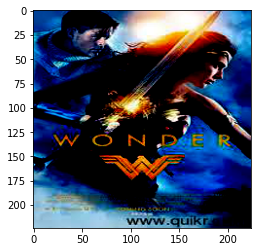

In [9]:
#### Add your code here ####
import matplotlib.pyplot as plt
plt.imshow(X_train[9])

Print the mask

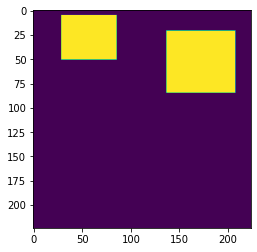

In [10]:
#### Add your code here ####
plt.imshow(y_train[9])

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [51]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
    block0= model.get_layer("conv_pw_1_relu").output
    block1= model.get_layer("conv_pw_3_relu").output
    block2= model.get_layer("conv_pw_5_relu").output
    block3= model.get_layer("conv_pw_11_relu").output
    block4= model.get_layer("conv_pw_13_relu").output

    deconv1 = Concatenate()([UpSampling2D()(block4), block3])
    deconv2 = Concatenate()([UpSampling2D()(deconv1), block2])
    deconv3 = Concatenate()([UpSampling2D()(deconv2), block1])
    deconv4 = Concatenate()([UpSampling2D()(deconv3), block0])
    x=UpSampling2D()(deconv4)
    x= Conv2D(1,kernel_size=1,activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)
    return Model(model.input, outputs = x)
    #### Add your code here ####

In [52]:
#model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")
#model.summary()

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [53]:
#### Add your code here ####
model=create_model()

(None, 224, 224)


### Print model summary (1 mark)

In [54]:
#### Add your code here ####
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


In [55]:
#### Add your code here ####
from tensorflow.math import reduce_sum
from tensorflow.keras.backend import epsilon

def calc_dice_coef(y_true, y_pred):
  intersection = reduce_sum(y_true * y_pred)
  denomiator = reduce_sum(y_true+y_pred)
  return (2*intersection+epsilon()) / (denomiator+epsilon())

### Define loss function (2 marks)

In [56]:
#### Add your code here ####
def dice_loss(y_true, y_pred):
  return 1- calc_dice_coef(y_true, y_pred)

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [57]:
#### Add your code here ####
model.compile(loss=dice_loss,optimizer="adam",metrics=[calc_dice_coef])

### Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [58]:
#### Add your code here ####
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
checkpoint= ModelCheckpoint(mode='min',filepath='checkpoint.h5',monitor='loss',save_best_only='True',save_weights_only='True',verbose=1)
es = EarlyStopping(mode = 'min', monitor=dice_loss, patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(mode = 'min', monitor='loss', factor=0.2, patience=2, min_lr=0.01)

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [59]:
#### Add your code here ####
model.fit(x=X_train,y=y_train,epochs=10,batch_size=1,callbacks=[checkpoint,reduce_lr,es])

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.5223 - calc_dice_coef: 0.4777
Epoch 00001: loss improved from inf to 0.52233, saving model to checkpoint.h5
400/400 [==============================] - 19s 47ms/step - loss: 0.5223 - calc_dice_coef: 0.4777
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.4356 - calc_dice_coef: 0.5644
Epoch 00002: loss improved from 0.52233 to 0.43557, saving model to checkpoint.h5
400/400 [==============================] - 19s 48ms/step - loss: 0.4356 - calc_dice_coef: 0.5644
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.3949 - calc_dice_coef: 0.6051
Epoch 00003: loss improved from 0.43557 to 0.39495, saving model to checkpoint.h5
400/400 [==============================] - 19s 48ms/step - loss: 0.3949 - calc_dice_coef: 0.6051
Epoch 4/10
399/400 [============================>.] - ETA: 0s - loss: 0.3810 - calc_dice_coef: 0.6190
Epoch 00004: loss improved from 0.39495 to 0.38066, saving 

### Get the predicted mask for a test image   (2 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


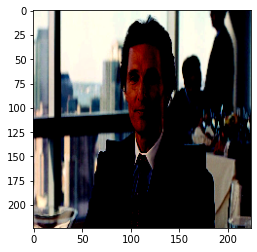

In [60]:
#### Add your code here ####
plt.imshow(X_test[3])

Show original mask for test image

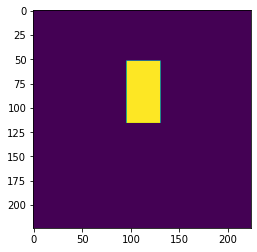

In [61]:
#### Add your code here ####
plt.imshow(y_test[3])

Predict the mask on the test image

In [62]:
#### Add your code here ####
m=3
pred_mask = model.predict(x=np.array([X_test[m]]))[0]>0.5

### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

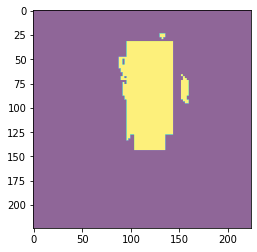

In [64]:
#### Add your code here ####
plt.imshow(pred_mask,alpha= 0.6)